# 项目：未前往就诊的挂号预约

## 目录
<ul>
<li><a href="#intro">简介</a></li>
<li><a href="#wrangling">数据整理</a></li>
<li><a href="#eda">探索性数据分析</a></li>
<li><a href="#conclusions">结论</a></li>
</ul>

<a id='intro'></a>
## 简介
本数据集包含10万条巴西预约挂号的求诊信息，研究病人是否如约前往医院就诊。每行数据录入了有关患者特点的多个数值，包括 “预约日期 (ScheduledDay)”指患者具体预约就诊的日期；“街区 (Neighborhood) ”指医院所在位置；“福利保障 (Scholarship)”说明病人是否是巴西福利项目 Bolsa Família 的保障人群；请注意最后一列内容的编码：“No”表示病人已如约就诊，“Yes”说明病人未前往就诊。
本次探索就是要深度研究：有哪些重要因素能够帮助我们预测患者是否会按照其挂号预约前往医院就诊？


In [71]:
# 用这个框对你计划使用的所有数据包设置
#   导入语句。
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline


# 务必包含一个‘咒语’，以便将你的视图
#   与 notebook 保持一致。关于更多信息，请访问这个网页：
#   http://ipython.readthedocs.io/en/stable/interactive/magics.html


In [72]:
# 载入数据
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')

In [73]:
# 获取基本信息
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


可以看到有 11w行数据，14列

In [4]:
# 查看下数据
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


字段从左到右依次为：

病人id，  预约流水，性别，实际就诊日期，预约日期，年龄，医院所属街道，是否享有福利项目，高血压，糖尿病，酗酒，伤残等级，短信预约，是否如约

In [5]:
# 查看各字段有几种数据
# 是否享有福利项目
df.groupby('Scholarship')['No-show'].count()
# 0 无 1 有

Scholarship
0    99666
1    10861
Name: No-show, dtype: int64

In [7]:
# 高血压
df.groupby('Hipertension')['No-show'].count()
# 0 无 1 有

Hipertension
0    88726
1    21801
Name: No-show, dtype: int64

In [8]:
# 糖尿病
df.groupby('Diabetes')['No-show'].count()
# 0 无 1 有

Diabetes
0    102584
1      7943
Name: No-show, dtype: int64

In [10]:
# 酗酒
df.groupby('Alcoholism')['No-show'].count()
# 0 无 1 有

Alcoholism
0    107167
1      3360
Name: No-show, dtype: int64

In [11]:
# 伤残等级
df.groupby('Handcap')['No-show'].count()
# 0-4 从低到高

Handcap
0    108286
1      2042
2       183
3        13
4         3
Name: No-show, dtype: int64

In [12]:
# 短信预约
df.groupby('SMS_received')['No-show'].count()
# 0 无 1 有

SMS_received
0    75045
1    35482
Name: No-show, dtype: int64

In [13]:
# 是否未前往
df.groupby('No-show')['No-show'].count()
# No 未前往 1 准时前往

No-show
No     88208
Yes    22319
Name: No-show, dtype: int64

<a id='wrangling'></a>
## 数据整理
1. 检查数据类型，字段名称
2. 缺失值
3. 重复值
4. 错误值


### 常规属性

In [9]:
# 加载数据并打印几行。进行几项操作，检查数据
#   类型，以及是否有缺失数据或错误数据。
# 原有字段
df.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show'],
      dtype='object')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [11]:
# 3.查看缺失值
df.isnull().any()

PatientId         False
AppointmentID     False
Gender            False
ScheduledDay      False
AppointmentDay    False
Age               False
Neighbourhood     False
Scholarship       False
Hipertension      False
Diabetes          False
Alcoholism        False
Handcap           False
SMS_received      False
No-show           False
dtype: bool

都是 Fasle，表示没有缺失值

In [12]:
# 查看重复行
sum(df.duplicated())

0

0 没有重复行

查看错误数据，这些列只有年龄有正常范围，先查看下是否有小于等于 0 的年龄，再看看最大年龄有没有不符合正常年龄的数据。

In [77]:
df[df['Age'] < 0]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
99832,4.659432e+14,5775010,F,2016-06-06T08:58:13Z,2016-06-06T00:00:00Z,-1,ROMÃO,0,0,0,0,0,0,No


有 1 个小于 0 的年龄，这是不正常的，应该清理掉

In [78]:
# 再查看是否有过大的年龄
max(df['Age'])

115

115 属于正常范围中的年龄，不需要清理

### 数据清理
首先，由于本次调查的目的是看哪些因素影响了病人准时就诊，所以我准备如下步骤
1. 删除前两个流水字段，与本课题无关
2. 将字段名称变成小写，驼峰变成下划线
3. 查看是否有缺失值，重复行，错误数据
4. 将两个日期列改为日期属性
5. 新增一列记录年龄分段：0-2 婴儿 3-10 儿童，11-18 青少年 19-35 青年 36-60 中年 60+ 老年
6. 将no_show转换为数字0, 1 ( 0 - no, 1 - yes)
7. 清理不正常的年龄数据

In [80]:
# 讨论数据结构和需要解决的任何问题之后，
#   在本段的第二部分进行这些清理步骤。
# 1.删除前两个流水字段，与本课题无关
df.drop(['PatientId', 'AppointmentID'], axis=1, inplace=True)

# 查看结果
df.columns

Index(['Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'Neighbourhood',
       'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap',
       'SMS_received', 'No-show'],
      dtype='object')

In [81]:
# 2.将字段名称变成小写，驼峰变成下划线
new_name = {
    'Gender':'gender',
    'ScheduledDay':'scheduled_day',
    'AppointmentDay':'appointment_day',
    'Age':'age',
    'Neighbourhood':'neighbourhood',
    'Scholarship':'scholarship',
    'Hipertension':'hipertension',
    'Diabetes':'diabetes',
    'Alcoholism':'alcoholism',
    'Handcap':'handcap',
    'SMS_received':'sms_received',
    'No-show':'no_show'
}
df.rename(columns=new_name, inplace=True)

# 查看结果
df.columns

Index(['gender', 'scheduled_day', 'appointment_day', 'age', 'neighbourhood',
       'scholarship', 'hipertension', 'diabetes', 'alcoholism', 'handcap',
       'sms_received', 'no_show'],
      dtype='object')

In [82]:
# 由于删除了两列流水字段，这里要重新查看是否有重复
sum(df.duplicated())

635

新增了 635 个重复行，需要清理掉

In [9]:
# 3.删除重复行
df.drop_duplicates(inplace=True)

# 查看结果
sum(df.duplicated())

0

In [83]:
# 删除年龄小于 0 的数据
temp_index = df[df['age'] < 0]['age'].index
df.drop(temp_index, inplace=True)

# 查看结果
df[df['age'] < 0]['no_show'].count()

0

小于 0 的年龄已经被清理

In [85]:
# 4.转换日期格式
df['scheduled_day'] = pd.to_datetime(df['scheduled_day'])
df['appointment_day'] = pd.to_datetime(df['appointment_day'])
# 查看结果
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110526 entries, 0 to 110526
Data columns (total 12 columns):
gender             110526 non-null object
scheduled_day      110526 non-null datetime64[ns]
appointment_day    110526 non-null datetime64[ns]
age                110526 non-null int64
neighbourhood      110526 non-null object
scholarship        110526 non-null int64
hipertension       110526 non-null int64
diabetes           110526 non-null int64
alcoholism         110526 non-null int64
handcap            110526 non-null int64
sms_received       110526 non-null int64
no_show            110526 non-null object
dtypes: datetime64[ns](2), int64(7), object(3)
memory usage: 11.0+ MB


In [86]:
df.describe()

,age,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received
count,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000
mean,37.089219,0.098266,0.197248,0.071865,0.030400,0.022248,0.321029
std,23.110026,0.297676,0.397923,0.258266,0.171686,0.161543,0.466874
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [87]:
# 5.新增年龄分段列 0-2 婴儿 3-10 儿童，11-18 青少年 19-35 青年 36-60 中年 60+ 老年
bin_edges = [-1, 2, 10, 18, 35, 60, 115]
bin_names = ['baby', 'child', 'teen-age', 'youth', 'midlife', 'old-age']
df['age_levels'] = pd.cut(df['age'], bin_edges, labels=bin_names)

In [88]:
# 6.no_show转换为数字0,1
df['no_show'].replace({'Yes':1, 'No':0}, inplace=True)

In [89]:
df.head()

# 数据清理完毕

,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no_show,age_levels
0,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,0,old-age
1,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,0,midlife
2,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,0,old-age
3,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,child
4,F,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,0,midlife


<a id='eda'></a>
## 探索性数据分析



### 各个变量所占的比重

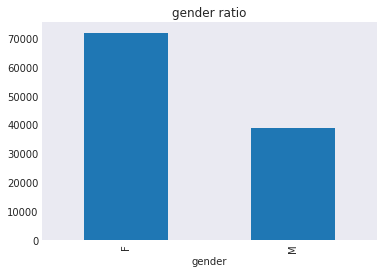

In [98]:
# 用这个代码框和其它代码框探索数据。务必添加
#   Markdown 框，以便归档你的观察和调查结果。
#df['gender'].hist(figsize=(5,5));
# 性别和未赴约的比重
df.groupby('gender')['no_show'].count().plot(kind = 'bar', title='gender ratio', x='gender', y='count');

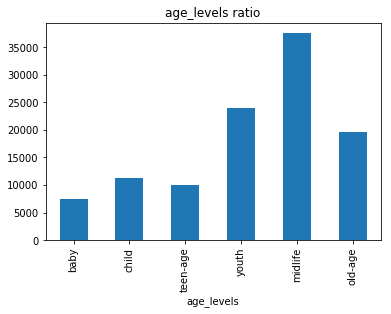

In [17]:
# 年龄段和未赴约的比重
df.groupby('age_levels')['no_show'].count().plot(kind = 'bar', title='age_levels ratio', x='age_levels', y='count');

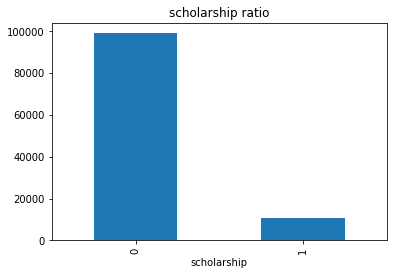

In [18]:
# df['scholarship'].hist(figsize=(3,3));
# 是否享有福利项目和未赴约的比重
df.groupby('scholarship')['no_show'].count().plot(kind = 'bar', title='scholarship ratio', x='scholarship', y='count');

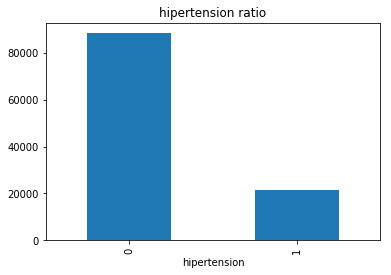

In [19]:
# df['hipertension'].hist(figsize=(3,3));
# 高血压和未赴约的比重
df.groupby('hipertension')['no_show'].count().plot(kind = 'bar', title='hipertension ratio', x='hipertension', y='count');

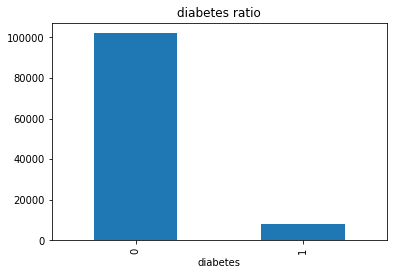

In [20]:
# df['diabetes'].hist(figsize=(3,3));
# 糖尿病和未赴约的比重
df.groupby('diabetes')['no_show'].count().plot(kind = 'bar', title='diabetes ratio', x='diabetes', y='count');

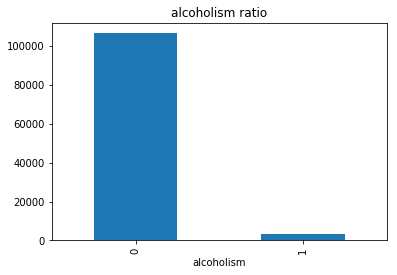

In [21]:
# df['alcoholism'].hist(figsize=(3,3));
# 酗酒和未赴约的比重
df.groupby('alcoholism')['no_show'].count().plot(kind = 'bar', title='alcoholism ratio', x='alcoholism', y='count');

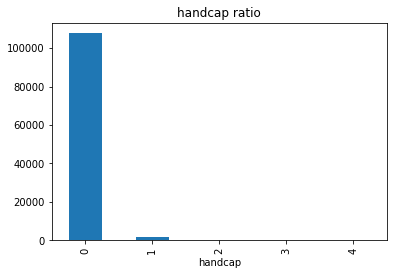

In [22]:
#df['handcap'].hist(figsize=(3,3));
# 伤残等级和未赴约的比重
df.groupby('handcap')['no_show'].count().plot(kind = 'bar', title='handcap ratio', x='handcap', y='count');

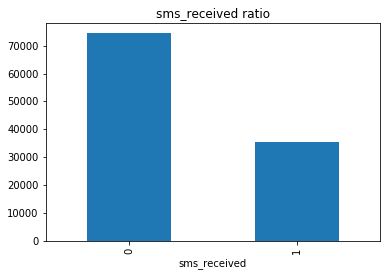

In [23]:
# df['sms_received'].hist(figsize=(3,3));
# 短信预约和未赴约的比重
df.groupby('sms_received')['no_show'].count().plot(kind = 'bar', title='sms_received ratio', x='sms_received', y='count');

In [24]:
df.columns

Index(['gender', 'scheduled_day', 'appointment_day', 'age', 'neighbourhood',
       'scholarship', 'hipertension', 'diabetes', 'alcoholism', 'handcap',
       'sms_received', 'no_show', 'age_levels'],
      dtype='object')

### 探索哪些因素和最终结果有关

In [25]:
def get_yes_percentage(column_name, condition):
    total_counts = sum(df[df[column_name] == condition]['no_show'].value_counts())
    result = df[(df[column_name] == condition) & (df['no_show'] == 1)]['no_show'].value_counts() / total_counts
    return result.get_value(label=1)
    

没有福利失约百分比 19.72%
有福利失约百分比 23.66%


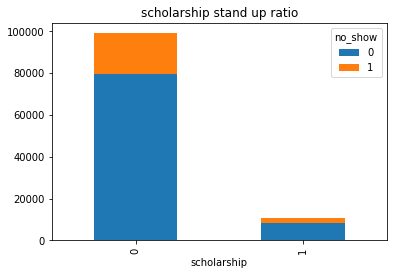

In [26]:
print("没有福利失约百分比 {:.2%}".format(get_yes_percentage('scholarship', 0)))
print("有福利失约百分比 {:.2%}".format(get_yes_percentage('scholarship', 1)))

df.groupby(['scholarship', 'no_show'])['no_show'].count().unstack().plot(kind = 'bar', stacked =True, title='scholarship stand up ratio');
#df[df['no_show'] == 1]['scholarship'].value_counts().plot(kind='bar', rot=0, figsize=(8, 3));

从这个条件中我并没有发现和最终是否失约有什么关系，难道是因为有福利 医生会上门就诊，所以肆无忌惮的可能性会大？

81
0
AEROPORTO
街道AEROPORTO失约百分比 12.50%
1
ANDORINHAS
街道ANDORINHAS失约百分比 22.65%
2
ANTÔNIO HONÓRIO
街道ANTÔNIO HONÓRIO失约百分比 18.45%
3
ARIOVALDO FAVALESSA
街道ARIOVALDO FAVALESSA失约百分比 22.14%
4
BARRO VERMELHO
街道BARRO VERMELHO失约百分比 21.56%
5
BELA VISTA
街道BELA VISTA失约百分比 20.06%
6
BENTO FERREIRA
街道BENTO FERREIRA失约百分比 22.13%
7
BOA VISTA
街道BOA VISTA失约百分比 18.59%
8
BONFIM
街道BONFIM失约百分比 19.85%
9
CARATOÍRA
街道CARATOÍRA失约百分比 22.94%
10
CENTRO
街道CENTRO失约百分比 21.00%
11
COMDUSA
街道COMDUSA失约百分比 17.82%
12
CONQUISTA
街道CONQUISTA失约百分比 18.65%
13
CONSOLAÇÃO
街道CONSOLAÇÃO失约百分比 17.24%
14
CRUZAMENTO
街道CRUZAMENTO失约百分比 21.63%
15
DA PENHA
街道DA PENHA失约百分比 19.43%
16
DE LOURDES
街道DE LOURDES失约百分比 15.56%
17
DO CABRAL
街道DO CABRAL失约百分比 15.77%
18
DO MOSCOSO
街道DO MOSCOSO失约百分比 22.38%
19
DO QUADRO
街道DO QUADRO失约百分比 16.31%
20
ENSEADA DO SUÁ
街道ENSEADA DO SUÁ失约百分比 22.13%
21
ESTRELINHA
街道ESTRELINHA失约百分比 19.70%
22
FONTE GRANDE
街道FONTE GRANDE失约百分比 21.78%
23
FORTE SÃO JOÃO
街道FORTE SÃO JOÃO失约百分比 17.92%
24
FRADINHOS
街道FRADINHOS失约百分比 18.60%
25
GOIAB

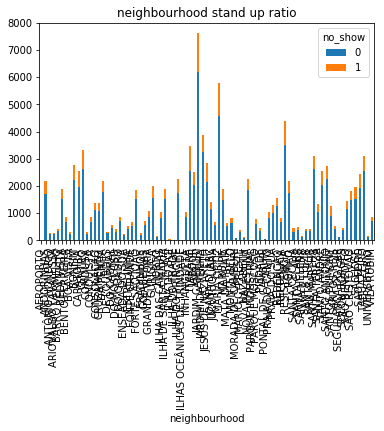

In [36]:
temp = df.groupby('neighbourhood')['no_show']
print(len(temp))
for i, k in enumerate(temp):
    print(i)
    print(k[0])
    try:
        print("街道{}失约百分比 {:.2%}".format(k[0], get_yes_percentage('neighbourhood', k[0])))
    except Exception as e:
        print(e)

# df[df['no_show'] == 1]['neighbourhood'].value_counts()[:5].plot(kind='bar', rot=0, figsize=(8, 3));
df.groupby(['neighbourhood', 'no_show'])['no_show'].count().unstack().plot(kind = 'bar', stacked =True, title='neighbourhood stand up ratio');
# JARDIM CAMBURI

街道ILHAS OCEÂNICAS DE TRINDADE失约百分比 100.00%
街道的失约比的话，我猜测就是因为医院所处的地理位置可能在交通上并不方便导致失约比会增高？

midlife失约百分比 19.00%
youth失约百分比 23.74%
old-age失约百分比 15.13%
teen-age失约百分比 25.25%
child失约百分比 21.86%
baby失约百分比 17.57%


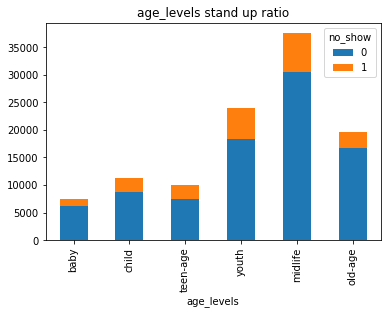

In [37]:
print("midlife失约百分比 {:.2%}".format(get_yes_percentage('age_levels', 'midlife')))
print("youth失约百分比 {:.2%}".format(get_yes_percentage('age_levels', 'youth')))
print("old-age失约百分比 {:.2%}".format(get_yes_percentage('age_levels', 'old-age')))
print("teen-age失约百分比 {:.2%}".format(get_yes_percentage('age_levels', 'teen-age')))
print("child失约百分比 {:.2%}".format(get_yes_percentage('age_levels', 'child')))
print("baby失约百分比 {:.2%}".format(get_yes_percentage('age_levels', 'baby')))

df.groupby(['age_levels', 'no_show'])['no_show'].count().unstack().plot(kind = 'bar', stacked =True, title='age_levels stand up ratio');

中年 青年 失约数目最多。难道是因为中青年因为对自己的健康比较盲目的自信，而且在这两个年龄段时，自我主导权也比较大？

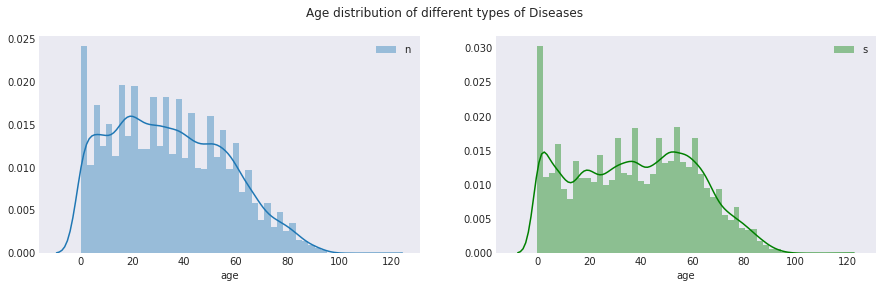

In [68]:
#设置背景及标题
sns.set_style('dark')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4), sharex=True)
f.suptitle('Age distribution of different types of Diseases')

#作图
sns.distplot(df[df['no_show']==1]['age'],ax=ax1)
sns.distplot(df[df['no_show']==0]['age'],color='g',ax=ax2)
#sns.distplot(df[df['alcoholism']==1]['age'],color='r',ax=ax3)
ax1.legend('no_show') # 爽约
ax2.legend('show') # 赴约

从图中并没有看出，年龄和赴约或爽约的绝对关系

有高血压失约百分比 20.82%
无高血压失约百分比 17.20%


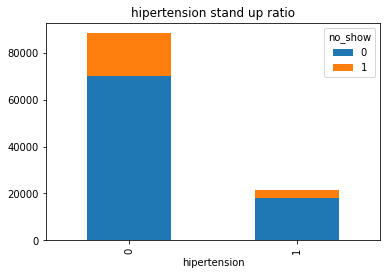

In [38]:
print("有高血压失约百分比 {:.2%}".format(get_yes_percentage('hipertension', 0)))
print("无高血压失约百分比 {:.2%}".format(get_yes_percentage('hipertension', 1)))
df.groupby(['hipertension', 'no_show'])['no_show'].count().unstack().plot(kind = 'bar', stacked =True, title='hipertension stand up ratio');
# df[df['no_show'] == 1]['hipertension'].value_counts().plot(kind='bar', rot=0, figsize=(8, 3));

我看不出此条件与最终结果的相关性

有糖尿病失约百分比 20.27%
无糖尿病失约百分比 18.02%


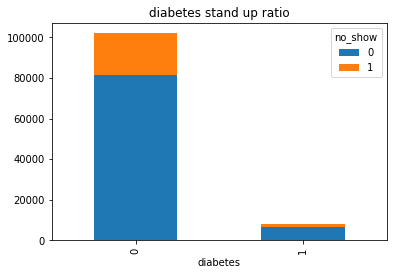

In [39]:
print("有糖尿病失约百分比 {:.2%}".format(get_yes_percentage('diabetes', 0)))
print("无糖尿病失约百分比 {:.2%}".format(get_yes_percentage('diabetes', 1)))

df.groupby(['diabetes', 'no_show'])['no_show'].count().unstack().plot(kind = 'bar', stacked =True, title='diabetes stand up ratio');
# df[df['no_show'] == 1]['diabetes'].value_counts().plot(kind='bar', rot=0, figsize=(8, 3));

我看不出此条件与最终结果的相关性

酗酒失约百分比 20.11%
不酗酒失约百分比 19.98%


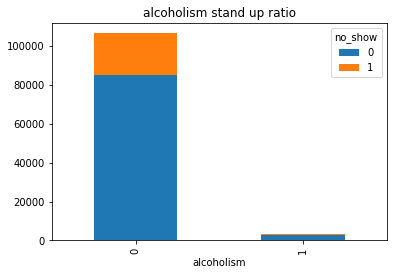

In [40]:
print("酗酒失约百分比 {:.2%}".format(get_yes_percentage('alcoholism', 0)))
print("不酗酒失约百分比 {:.2%}".format(get_yes_percentage('alcoholism', 1)))

df.groupby(['alcoholism', 'no_show'])['no_show'].count().unstack().plot(kind = 'bar', stacked =True, title='alcoholism stand up ratio');
# df[df['no_show'] == 1]['alcoholism'].value_counts().plot(kind='bar', rot=0, figsize=(8, 3));

我看不出此条件与最终结果的相关性

无伤残失约百分比 20.15%
伤残等级1失约百分比 17.70%
伤残等级2失约百分比 20.33%
伤残等级3失约百分比 27.27%
伤残等级4失约百分比 33.33%


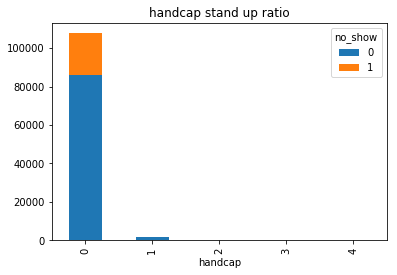

In [28]:
print("无伤残失约百分比 {:.2%}".format(get_yes_percentage('handcap', 0)))
print("伤残等级1失约百分比 {:.2%}".format(get_yes_percentage('handcap', 1)))
print("伤残等级2失约百分比 {:.2%}".format(get_yes_percentage('handcap', 2)))
print("伤残等级3失约百分比 {:.2%}".format(get_yes_percentage('handcap', 3)))
print("伤残等级4失约百分比 {:.2%}".format(get_yes_percentage('handcap', 4)))

df.groupby(['handcap', 'no_show'])['no_show'].count().unstack().plot(kind = 'bar', stacked =True, title='handcap stand up ratio');
# df[df['no_show'] == 1]['handcap'].value_counts().plot(kind='bar', rot=0, figsize=(8, 3));

伤残等级高，所以行动不便，所以失约比会高？

未短信预约失约百分比 16.55%
短信预约失约百分比 27.57%
<class 'pandas.core.series.Series'>


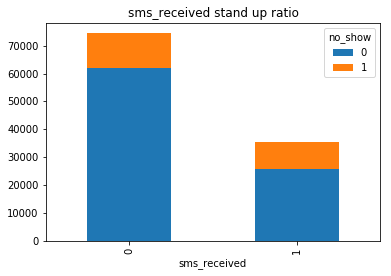

In [53]:
print("未短信预约失约百分比 {:.2%}".format(get_yes_percentage('sms_received', 0)))
print("短信预约失约百分比 {:.2%}".format(get_yes_percentage('sms_received', 1)))

received_count = df.groupby('sms_received').size()
print(type(received_count))

sms_received_noshow_count = df.groupby(['sms_received', 'no_show'])['no_show'].count().unstack()
#sms_received_noshow_count.plot(kind='pie', labels=['received','No received'], autopct='%.1f%%',subplots=True);
sms_received_noshow_count.plot(kind = 'bar', stacked =True, title='sms_received stand up ratio');

我看不出此条件与最终结果的相关性

<a id='conclusions'></a>
## 结论

> **提示**：最后，总结你的调查结果。确保了解探索结果的限制。如果尚未进行任何统计检验，不要做出任何统计结论。切记不要根据相互关系推导出因果关系！

此次调查存在的限制：
1. 此次针对病人是否失约，总共的数据量只有11w左右，数据量不足导致有些特征的数量太小，无法根据现有的数据得出明显结论
2. 此次数据所提供的字段，从直观层面上并不认为和最终失约会有强关联，一切只能从现有数据分析结果猜测可能存在的线性关系
3. 最后就是可能此次分析并未针对多个字段同时进行分组分析


> 如需将报告导出到工作区，应运行下面的代码框。如果正确，会返回代码 0，工作区目录下会生成 .html 文件（单击左上角的 jupyter 图标）。也可以通过 **文件** > **下载为** 子菜单下载 html 报告，然后手动上传到工作区目录。完成之后，可以单击右下角的“提交项目”，提交你的项目。恭喜！

**最后结论**（只能从现有结果出发）：
1. ILHAS OCEÂNICAS DE TRINDADE 街道 失约率 100%
2. 伤残等级4 失约率 33.33%
3. SANTA CECÍLIA 街道 失约率 27.46%
4. 伤残等级3 失约率 27.27%

根据结果猜测的话： **街道方面原因可能是医院地理位置 交通不便利导致的，而伤残等级则是由于病患本身行动不便导致的失约**

In [81]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

255